# GEP 
Finetune the model with the GEP objective using PDAC cells

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
from pathlib import Path
import json
from tqdm import tqdm
import warnings
import time
from einops import rearrange # for attention
import pickle
import copy

import torch
from torch import nn
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import scgpt as scg
from scgpt.tokenizer.gene_tokenizer import GeneVocab
from scgpt.preprocess import Preprocessor
from scgpt.model import TransformerModel
from scgpt.tokenizer import tokenize_and_pad_batch, random_mask_value
from scgpt.loss import masked_mse_loss

/bin/bash: /homes8/runzi/.conda/envs/scgpt/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [2]:
device = 'cuda'

In [3]:
params = dict(# data processing
gene_col = 'gene',
label_col = None,
data_is_raw = False,
filter_gene_by_counts = False,
input_layer_key = 'X_binned',
max_seq_len = 3001, # changed 
batch_size = 32, # training setup

# model/training only configs
domain_spec_batchnorm = 'batchnorm',
input_emb_style = "continuous",
cell_emb_style = "cls",
n_input_bins = 51,
mvc_decoder_style  = "inner product",
ecs_threshold = 0.0 ,
explicit_zero_prob = False,
use_fast_transformer = True,
fast_transformer_backend = "flash",
pre_norm = False,

n_layers_cls = 3,
nhead = 8,
embsize = 512,
d_hid = 512,
nlayers = 12,
dropout = 0.2,

lr = 1e-4,
amp  = True,
schedule_ratio=0.9,
save_eval_interval=5,
log_interval = 100,
schedule_interval = 1,

ADV = False,
MLM = True, # for masked prediction training
MVC = False,
CLS = False,
DAB = False,
CCE = False,
ECS = False,
do_sample_in_train = False,
INPUT_BATCH_LABELS = False,
num_batch_labels = None,

epochs = 15,

# model and data processing
n_bins = 51,
include_zero_gene = False, # tokenization, but affects model's setup/behavior
pad_token = '<pad>',
mask_value = -1,
pad_value = -2)

In [4]:
data_dir = Path('/cristealab/rtan/scGPT/VDR/data')
model_dir = Path('/cristealab/rtan/scGPT/models/whole_human')
save_dir = Path('/cristealab/rtan/scGPT/VDR/save')
pancancer_dir = Path('/cristealab/rtan/scGPT/models/pan_cancer')

In [5]:
VDR = sc.read(data_dir/'VDR.h5ad')

In [6]:
PDAC = VDR[VDR.obs.celltype=='PDAC']

In [7]:
# 10 samples with more than 1000 PDAC cells
sum(PDAC.obs.groupby(['patientID']).size()>1000)

10

In [8]:
pids = PDAC.obs.groupby(['patientID']).size().index[PDAC.obs.groupby(['patientID']).size()>1000]

In [9]:
PDAC = PDAC[PDAC.obs.patientID.isin(pids)]

In [10]:
PDAC.var = pd.read_csv(data_dir/'PDAC_hvgs.cvs', index_col=0)

In [11]:
# filter genes by vocab
vocab_file = model_dir / "vocab.json"
vocab = GeneVocab.from_file(vocab_file)

PDAC.var["id_in_vocab"] = [1 if gene in vocab else -1 for gene in PDAC.var[params['gene_col']]]

gene_ids_in_vocab = np.array(PDAC.var["id_in_vocab"])
print(
  f"match {np.sum(gene_ids_in_vocab >= 0)}/{len(gene_ids_in_vocab)} genes "
  f"in vocabulary of size {len(vocab)}."
)
PDAC = PDAC[:, PDAC.var["id_in_vocab"] >= 0]

# keep top 3000 hvgs
hvgs_index = PDAC.var.nlargest(3000, 'variances_norm').index
PDAC = PDAC[:, hvgs_index]
PDAC.shape

match 24285/36601 genes in vocabulary of size 60697.


(21633, 3000)

In [12]:
# binning
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=params['filter_gene_by_counts'],  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=False,  # 3. whether to normalize the raw data and to what sum
    # result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=params['data_is_raw'],  # 4. whether to log1p the normalized data
    # result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    # hvg_flavor="seurat_v3" if data_is_raw else "cell_ranger",
    binning=params['n_bins'],  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X_binned",  # the key in adata.layers to store the binned data
)

In [13]:
preprocessor(PDAC)

scGPT - INFO - Filtering cells by counts ...
scGPT - INFO - Binning data ...


/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:137: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['n_counts'] = number


In [14]:
# keep 1000 cells for each
def split(adata, cols, numbers, seed):
    adata_obs = adata.obs[cols]
    adata_obs.loc[:,'row'] = range(0,adata.n_obs)
    selection = adata_obs.groupby(cols).size()
    selected_indices = []
    for index in range(len(numbers)):
        df = adata_obs[(adata_obs[cols]==selection.index[index]).all(axis=1)]
        np.random.seed(123)
        selected_indices += df['row'][np.random.choice(df.shape[0], numbers[index], replace=False)].tolist()
    selected_indices.sort()

    return adata[selected_indices]
subPDAC = split(PDAC, ['patientID'], [1000]*6, 123)

/homes8/runzi/.conda/envs/scgpt/lib/python3.8/site-packages/pandas/core/indexing.py:1667: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value


In [15]:
# define a function which receives adata and gives data_pt
def adata_to_pt(adata, gene_col='gene', layer_key='X_binned',include_zero = False, CLS = False):
    '''
    from adata to pt
    layer_key: need to consider 'X'
    '''
    all_counts = adata.layers[layer_key]
    genes = adata.var[gene_col].tolist()
    gene_ids = np.array(vocab(genes), dtype=int)
    max_seq_len = max(np.sum(adata.layers[layer_key]>0, axis = 1))+1

    tokenized_all = tokenize_and_pad_batch(
        all_counts,
        gene_ids,
        max_len=max_seq_len,
        vocab=vocab,
        pad_token=params['pad_token'],
        pad_value=params['pad_value'],
        append_cls=True,  # append <cls> token at the beginning
        include_zero_gene=include_zero,
    )
    tokenized_all['values'] = torch.tensor(tokenized_all['values'], dtype = torch.float)
    if CLS:
        tokenized_all['label_ids'] = torch.from_numpy(np.array(adata.obs.label_id)).long()
    pt = {
        "gene_ids": tokenized_all['genes'],
        "values": tokenized_all['values'],
    }
    if CLS: 
        pt["labels"] = tokenized_all['label_ids'],
    return pt

def mask(data_pt, mask_ratio=0):
    masked_values = random_mask_value(
    data_pt["values"],
    mask_ratio=mask_ratio,
    mask_value=-1,
    pad_value=-2,
    )
    data_pt.update({'masked_values':masked_values})
    return data_pt

In [16]:
len(pids)

10

In [17]:
# prepare pt
train_data, test_data = train_test_split(subPDAC, test_size= 0.2, stratify=subPDAC.obs.patientID, shuffle=True, random_state=123)
train_data, valid_data = train_test_split(train_data, test_size= 0.25, stratify=train_data.obs.patientID, shuffle=True, random_state=123)


In [37]:
subPDAC.shape

(6000, 3000)

In [18]:
# use 1000 cells for training
train_pt = adata_to_pt(subPDAC)
train_pt = mask(train_pt, mask_ratio = 0.4)
valid_pt = adata_to_pt(valid_data)
valid_pt = mask(valid_pt, mask_ratio = 0.4)
test_pt = adata_to_pt(test_data)
test_pt = mask(test_pt, mask_ratio = 0.4)

/tmp/ipykernel_990053/3624361991.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tokenized_all['values'] = torch.tensor(tokenized_all['values'], dtype = torch.float)


In [19]:
# dataset
class SeqDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data["gene_ids"].shape[0]

    def __getitem__(self, idx):
        return {k: v[idx] for k, v in self.data.items()}
    

# data_loader
def prepare_dataloader(
    data_pt,
    batch_size: int,
    shuffle: bool = True,
    intra_domain_shuffle: bool = False,
    drop_last: bool = False,
    num_workers: int = 0,
) -> DataLoader:
    if num_workers == 0:
        num_workers = min(len(os.sched_getaffinity(0)), batch_size // 2)

    dataset = SeqDataset(data_pt)

    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers,
        pin_memory=True,
    )
    return data_loader

## load pretrained model

In [20]:
# load pretrained model
# pretrained model
model_file = model_dir / "best_model.pt"
ntokens = len(vocab)  # size of vocabulary
model = TransformerModel(
    len(vocab),
    params['embsize'],
    params['nhead'],
    params['d_hid'],
    params['nlayers'],
    vocab=vocab,
    pad_token=params['pad_token'],
    pad_value=params['pad_value'],
    domain_spec_batchnorm=params['domain_spec_batchnorm'],
    n_input_bins=params['n_input_bins'],
    use_fast_transformer=params['use_fast_transformer'],
    pre_norm=params['pre_norm'],
)
# to avoid error since batch is not present in input data
model.domain_spec_batchnorm=False
# load parameters
if True:
        # only load params that are in the model and match the size
        model_dict = model.state_dict()
        pretrained_dict = torch.load(model_file)
        pretrained_dict = {
            k: v
            for k, v in pretrained_dict.items()
            if k in model_dict and v.shape == model_dict[k].shape
        }
        for k, v in pretrained_dict.items():
            print(f"Loading params {k} with shape {v.shape}")
        model_dict.update(pretrained_dict)
        model.load_state_dict(model_dict)



Using simple batchnorm instead of domain specific batchnorm
Loading params encoder.embedding.weight with shape torch.Size([60697, 512])
Loading params encoder.enc_norm.weight with shape torch.Size([512])
Loading params encoder.enc_norm.bias with shape torch.Size([512])
Loading params value_encoder.linear1.weight with shape torch.Size([512, 1])
Loading params value_encoder.linear1.bias with shape torch.Size([512])
Loading params value_encoder.linear2.weight with shape torch.Size([512, 512])
Loading params value_encoder.linear2.bias with shape torch.Size([512])
Loading params value_encoder.norm.weight with shape torch.Size([512])
Loading params value_encoder.norm.bias with shape torch.Size([512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.weight with shape torch.Size([1536, 512])
Loading params transformer_encoder.layers.0.self_attn.Wqkv.bias with shape torch.Size([1536])
Loading params transformer_encoder.layers.0.self_attn.out_proj.weight with shape torch.Size([512, 512

In [21]:
# for comparing before/after fine-tuning
pretrained = copy.deepcopy(model)

In [22]:
criterion = masked_mse_loss
criterion_cls = nn.CrossEntropyLoss()
criterion_dab = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=params['lr'], eps=1e-4 if params['amp'] else 1e-8
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer, params['schedule_interval'], gamma=params['schedule_ratio']
)

scaler = torch.cuda.amp.GradScaler(enabled=params['amp'])

In [23]:
def train(model: nn.Module, loader: DataLoader) -> None:
    """
    Train the model for one epoch.
    """
    model.train()
    (
        total_loss,
        total_mse,
    ) = (0.0, 0.0)
    total_error = 0.0 # report multiple loss and error
    # error is 1-accuracy for classification prediction in this task
    start_time = time.time()

    num_batches = len(loader)
    log_interval = np.floor(num_batches/3)
    for batch, batch_data in enumerate(loader):
        input_gene_ids = batch_data["gene_ids"].to(device)
        input_values = batch_data["masked_values"].to(device)
        target_values = batch_data["values"].to(device)
        # arm_labels = batch_data["labels"].to(device)

        src_key_padding_mask = input_gene_ids.eq(vocab[params['pad_token']])
        with torch.cuda.amp.autocast(enabled=params['amp']):
            output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=None,
                CLS=params['CLS'],
                CCE=params['CCE'],
                MVC=params['MVC'],
                ECS=params['ECS'],
                do_sample=params['do_sample_in_train'],
                #generative_training=False
            )

            masked_positions = input_values.eq(params['mask_value'])  # the postions to predict

            # loss for this batch
            loss = 0.0
            # keep losses for this batch
            metrics_to_log = {}
            if params['MLM']:
                loss_mse = criterion(
                    output_dict["mlm_output"], target_values, masked_positions
                )
                loss = loss + loss_mse
                metrics_to_log = {"train/mse": loss_mse.item()}
            
            
        # after calculating the results within the batch, update 
        model.zero_grad()
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        
        with warnings.catch_warnings(record=True) as w:
            warnings.filterwarnings("always")
            torch.nn.utils.clip_grad_norm_(
                model.parameters(),
                1.0,
                error_if_nonfinite=False if scaler.is_enabled() else True,
            )
            if len(w) > 0:
                print(
                    f"Found infinite gradient. This may be caused by the gradient "
                    f"scaler. The current scale is {scaler.get_scale()}. This warning "
                    "can be ignored if no longer occurs after autoscaling of the scaler."
                )
        scaler.step(optimizer)
        scaler.update()
 
        #wandb.log(metrics_to_log)
        # after some batches, report progress: total_loss etc. are used to calculate mean performance of those batches
        total_loss += loss.item()
        total_mse += loss_mse.item() if params['MLM'] else ""
        if batch % log_interval == 0 and batch > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            cur_mse = total_mse / log_interval
            # ppl = math.exp(cur_loss)
            print(
                f"| epoch {epoch:3d} | {batch:3d}/{num_batches:3d} batches | "
                f"lr {lr:05.4f} | ms/batch {ms_per_batch:5.2f} | "
                f"loss {cur_loss:5.2f} | "
                + (f"mse {cur_mse:5.2f} | " if params['MLM'] else "")
            )
            total_loss = 0
            total_mse = 0
            start_time = time.time()



def evaluate(model: nn.Module, loader: DataLoader, return_raw: bool = False) -> float:
    """
    Evaluate the model on the evaluation data.
    """
    model.eval()
    total_loss = 0.0
    total_num = 0
    predictions = []
    with torch.no_grad():
        for batch_data in loader:
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["masked_values"].to(device)
            target_values = batch_data["values"].to(device)
            masked_positions = input_values.eq(params['mask_value'])

            src_key_padding_mask = input_gene_ids.eq(vocab[params['pad_token']])
            with torch.cuda.amp.autocast(enabled=params['amp']):
                output_dict = model(
                input_gene_ids,
                input_values,
                src_key_padding_mask=src_key_padding_mask,
                batch_labels=None,
                CLS=params['CLS'],
                CCE=params['CCE'],
                MVC=params['MVC'],
                ECS=params['ECS'],
                do_sample=params['do_sample_in_train'],
                #generative_training=False
            )
                output_values = output_dict["mlm_output"]
                loss = criterion(
                    output_values, target_values, masked_positions
                )


            total_loss += loss.item() * len(input_gene_ids)
            total_num += len(input_gene_ids)
    '''
    wandb.log(
        {
            "valid/mse": total_loss / total_num,
            "valid/err": total_error / total_num,
            "valid/dab": total_dab / total_num,
            "valid/sum_mse_dab": (total_loss + dab_weight * total_dab) / total_num,
            "epoch": epoch,
        },
    )'''

    '''if return_raw:
        return np.concatenate(predictions, axis=0)'''

    return total_loss / total_num

## train model

In [24]:
best_val_loss = float("inf")
best_avg_bio = 0.0
best_model = None

model.to(device)
for epoch in range(1, params['epochs'] + 1):
    epoch_start_time = time.time()
    train_loader = prepare_dataloader(
        train_pt,
        batch_size=params['batch_size'],
        shuffle=False,
        intra_domain_shuffle=True,
        drop_last=False,
    )
    valid_loader = prepare_dataloader(
        valid_pt,
        batch_size=params['batch_size'],
        shuffle=False,
        intra_domain_shuffle=False,
        drop_last=False,
    )

    if True:
        train(
            model,
            loader=train_loader,
        )
    val_loss = evaluate(
        model,
        loader=valid_loader,
    )
    elapsed = time.time() - epoch_start_time
    print("-" * 89)
    print(
        f"| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | "
        f"valid loss/mse {val_loss:5.4f}"
    )
    print("-" * 89)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = copy.deepcopy(model)
        best_model_epoch = epoch
        print(f"Best model with score {best_val_loss:5.4f}")

    scheduler.step()
    # if (epoch - best_model_epoch)>3: break # early break
# 15 epochs, 6m32s 

| epoch   1 |  62/188 batches | lr 0.0001 | ms/batch 286.76 | loss 213.09 | mse 213.09 | 
| epoch   1 | 124/188 batches | lr 0.0001 | ms/batch 124.03 | loss 196.07 | mse 196.07 | 


| epoch   1 | 186/188 batches | lr 0.0001 | ms/batch 125.89 | loss 184.59 | mse 184.59 | 
-----------------------------------------------------------------------------------------
| end of epoch   1 | time: 38.62s | valid loss/mse 183.5351
-----------------------------------------------------------------------------------------
Best model with score 183.5351
| epoch   2 |  62/188 batches | lr 0.0001 | ms/batch 180.93 | loss 183.53 | mse 183.53 | 
| epoch   2 | 124/188 batches | lr 0.0001 | ms/batch 125.53 | loss 184.83 | mse 184.83 | 
| epoch   2 | 186/188 batches | lr 0.0001 | ms/batch 126.57 | loss 174.32 | mse 174.32 | 
-----------------------------------------------------------------------------------------
| end of epoch   2 | time: 32.42s | valid loss/mse 170.4101
-----------------------------------------------------------------------------------------
Best model with score 170.4101
| epoch   3 |  62/188 batches | lr 0.0001 | ms/batch 181.13 | loss 176.86 | mse 176.86 | 
| epoch 

In [25]:
def GEP(model, data_pt, masked_prediction = False):
    if masked_prediction: print('Return prediction values for masked positions')
    else: print('Return predictions for all positions')
    data = SeqDataset(data_pt)
    # no shuffle
    loader = DataLoader(
            data,
            batch_size=params['batch_size'],
            shuffle=False,
            drop_last=False,
            num_workers=min(len(os.sched_getaffinity(0)), params['batch_size'] // 2)
        )
    model.eval()
    model.to(device)
    predictions = []
    true_values = []
    total_loss = 0
    total_num = len(data_pt['gene_ids'])
    # device = next(model.parameters()).device
    with torch.no_grad():
        for batch, batch_data in enumerate(loader):
            input_gene_ids = batch_data["gene_ids"].to(device)
            input_values = batch_data["masked_values"].to(device) if masked_prediction else batch_data["values"].to(device)
            target_values = batch_data["values"].to(device)
            batch_len = input_gene_ids.shape[0]

            src_key_padding_mask = input_gene_ids.eq(vocab[params['pad_token']]).to(device)
            with torch.cuda.amp.autocast(enabled=True):
                output_dict = model(
                    input_gene_ids,
                    input_values,
                    src_key_padding_mask=src_key_padding_mask,
                    batch_labels=None,
                    CLS=False,  # evaluation does not need CLS or CCE
                    CCE=False,
                    MVC=False,
                    ECS=False,
                    do_sample=False,
                    #generative_training = False,
                )
                masked_positions = input_values.eq(params['mask_value'])
                total_loss += (criterion(output_dict["mlm_output"], target_values,masked_positions)).item()*len(input_gene_ids)
                for i in range(batch_len): # get results for each cell
                    if masked_prediction:
                        masked_positions = input_values[i].eq(params['mask_value']).to('cpu')
                        output_values = output_dict["mlm_output"][i].to('cpu')[masked_positions]
                        output_target_values = target_values[i].to('cpu')[masked_positions]
                    else:
                        nonzero_positions = (input_values[i]>0).to('cpu')
                        output_values = output_dict["mlm_output"][i].to('cpu')[nonzero_positions]
                        output_target_values = target_values[i].to('cpu')[nonzero_positions]
                    

                    predictions.append(output_values.tolist())
                    true_values.append(output_target_values.tolist())
                
    mse = total_loss/total_num
    return predictions, true_values, mse

## show fine-tuned and pre-trained for predicting values

In [27]:
# 40% masked
results = GEP(best_model, test_pt, masked_prediction=True)
results[2]

Return prediction values for masked positions


167.53921447753908

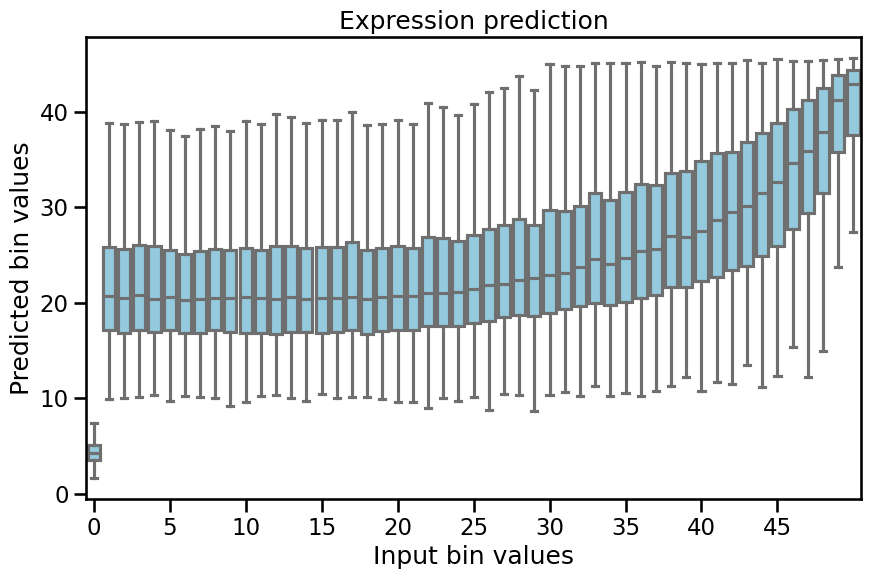

In [28]:
pre = []
for i in results[0]: pre=pre+i
true = []
for i in results[1]: true = true+i
data = pd.DataFrame({'X': true, 'Y': pre})
# Create a boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='X', y='Y', data=data, showfliers=False, color='skyblue')

# Alternatively, create a violin plot
# sns.violinplot(x='X', y='Y', data=data)

plt.title('Expression prediction')
plt.xlabel('Input bin values')
plt.ylabel('Predicted bin values')
selected_labels = np.arange(0,50, 5 )
plt.xticks(ticks=selected_labels, labels=selected_labels)
plt.show()